In [218]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import functions as fn

import sklearn 
import statsmodels.api as sm

In [219]:
# Read in the list of teams
teams = pd.read_csv('DataFiles/Teams.csv')
seasons_data = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
file_list = {}
years = ['18','17','16','15','14','13','12','11','10','09','08','07','06','05','04','03','02','01','00']

# Read in the data files from sports-reference.com
for s in years:
    filepath = ('WebData/ratings_' + s + '.csv')
    raw_data = pd.read_csv(filepath).drop(['Unnamed: 3', 'Unnamed: 9', 'Unnamed: 11'], axis=1)
    # We need only the school name and the rank
    raw_data = raw_data[['Rk', 'School']].dropna()
    raw_data = raw_data[(raw_data['Rk']).str.isnumeric()]
    file_list[s] = raw_data

In [220]:
# Extract the dataframes from the list
df_18 = file_list['18']
df_17 = file_list['17']
df_16 = file_list['16']
df_15 = file_list['15']
df_14 = file_list['14']
df_13 = file_list['13']
df_12 = file_list['12']
df_11 = file_list['11']
df_10 = file_list['10']
df_09 = file_list['09']
df_08 = file_list['08']
df_07 = file_list['07']
df_06 = file_list['06']
df_05 = file_list['05']
df_04 = file_list['04']
df_03 = file_list['03']
df_02 = file_list['02']
df_01 = file_list['01']
df_00 = file_list['00']
# Rename the columns
df_18.columns = ['2018', 'School']
df_17.columns = ['2017', 'School']
df_16.columns = ['2016', 'School']
df_15.columns = ['2015', 'School']
df_14.columns = ['2014', 'School']
df_13.columns = ['2013', 'School']
df_12.columns = ['2012', 'School']
df_11.columns = ['2011', 'School']
df_10.columns = ['2010', 'School']
df_09.columns = ['2009', 'School']
df_08.columns = ['2008', 'School']
df_07.columns = ['2007', 'School']
df_06.columns = ['2006', 'School']
df_05.columns = ['2005', 'School']
df_04.columns = ['2004', 'School']
df_03.columns = ['2003', 'School']
df_02.columns = ['2002', 'School']
df_01.columns = ['2001', 'School']
df_00.columns = ['2000', 'School']

In [221]:
# Merge the dataframes
from functools import reduce
data_frames = [df_18, df_17, df_16, df_15, df_14, df_13, df_12, df_11, df_10, df_09, df_08, 
               df_07, df_06, df_05, df_04, df_03, df_02, df_01, df_00]

team_ranks_df = reduce(lambda left, right: pd.merge(left, right, on=['School'], how='outer'), data_frames)

team_ranks_df = team_ranks_df.dropna().reset_index().drop('index', axis=1)

In [222]:
# Convert the rankings to integers
for col in team_ranks_df.columns:
    if str(col) != 'School':
        team_ranks_df[col] = team_ranks_df[col].astype(int)
        
team_ranks_df.head()

,2018,School,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,1,Villanova,5,1,5,9,51,71,23,17,14,47,19,6,13,50,59,50,75,72
1,2,Duke,9,12,2,6,4,12,2,1,6,5,11,2,3,1,6,1,1,2
2,3,Purdue,15,9,34,71,64,24,8,13,18,31,27,145,87,51,22,67,28,24
3,4,Michigan State,42,4,17,7,12,5,34,23,13,16,17,33,7,38,19,23,4,3
4,5,Virginia,13,5,6,14,41,34,92,68,85,76,46,83,72,58,72,36,12,40


In [223]:
team_ranks_df.to_csv('TeamRankings.csv')

### Look at the autocorrelation of the team rankings

In [224]:
ac_data = team_ranks_df.drop(['School'], axis=1)
# Create a list of lists of the autocorrelation 
ac_list = []

for i in ac_data.index:
    d = ac_data.loc[i].values.astype(float)
    ac = sm.tsa.stattools.acf(d)
    ac_list.append(ac)

In [225]:
# Data for plotting
plot_data = []
for i in range(0, len(ac_list[0])):
    r_list = []
    for ac in ac_list:
        x = ac[i]
        r_list.append(x)
    plot_data.append(r_list)

plot_data = plot_data[1:]

In [226]:
labels = []

for c in ac_data.columns[1:]:
    labels.append(c)

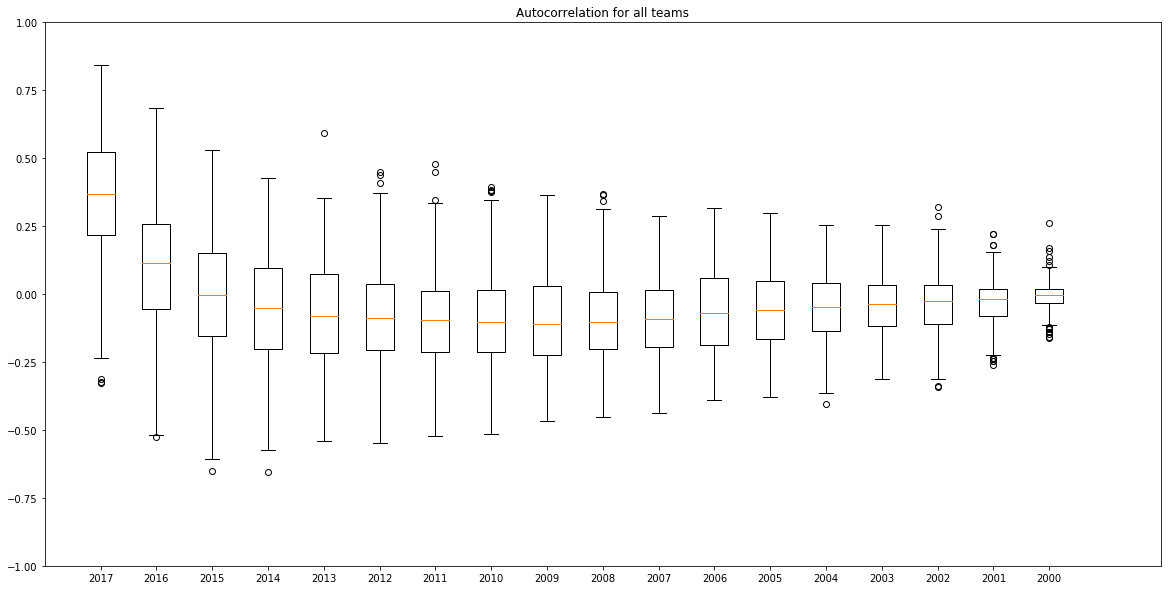

In [227]:
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title('Autocorrelation for all teams')
_= plt.boxplot(plot_data, labels = labels)
plt.axis([0, 20, -1, 1])
plt.savefig('Autocorrelation_boxplots.png')
plt.show()

In [281]:
# Look at the regular season data
seasons_data.head()
seasons_data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [229]:
#Include only teams that have been Division I teams in the years included in the rankings data
teams = teams[teams.LastD1Season > 1999]

# Replace 'St' with 'State' in the TeamName column to correspond to the School column in the rest of the data
schools = []
for t in teams.TeamName:
    name = str(t)
    r_name = re.sub(' St', " State", name)
    schools.append(r_name)

teams.TeamName = schools
print(len(teams.TeamName.unique()))

357


In [230]:
# Create a dictionary with the team name and team id
teams_dict = {}

for i in teams.index:
    teams_dict[teams.TeamName[i]] = teams.TeamID[i]

# Create a dataframe with the team name and team id
team_id_df = pd.DataFrame()
team_id_df['TeamName'] = teams_dict.keys()
team_id_df['TeamID'] = teams_dict.values()

team_id_df.to_csv('Team_id_pairs.csv')

In [231]:
# Create a list with the team ids
team_id_list = []

for i in team_ranks_df.index:
    s = str(team_ranks_df.School[i])
    if s in teams_dict:
        team_id = teams_dict[s]
        team_id_list.append(team_id)
    elif s not in teams_dict:
        team_id_list.append(np.nan)
        
team_ranks_df['TeamID'] = team_id_list

team_ranks_df = team_ranks_df.set_index('TeamID')

### Create a dataframe with the average field goal rate for each team for 2008 - 2018



In [373]:
# Extract the data needed
fg_data = seasons_data[seasons_data.Season>2007][['Season', 'WTeamID', 'LTeamID', 'WFGM', 'WFGA', 'LFGM', 'LFGA']]

fg_data['Lfgr'] = fg_data.LFGM/fg_data.LFGA
fg_data['Wfgr'] = fg_data.WFGM/fg_data.WFGA
fg_data.head()

,Season,WTeamID,LTeamID,WFGM,WFGA,LFGM,LFGA,Lfgr,Wfgr
23662,2008,1272,1404,37,83,24,77,0.311688,0.445783
23663,2008,1350,1263,17,51,19,45,0.422222,0.333333
23664,2008,1205,1105,21,59,17,49,0.346939,0.355932
23665,2008,1246,1146,26,55,10,50,0.200000,0.472727
23666,2008,1272,1350,25,51,24,63,0.380952,0.490196


In [374]:
years = fg_data.Season.unique()
Wteams = fg_data.WTeamID.unique()
Lteams = fg_data.LTeamID.unique()

fgr_all = []

for y in years:
    df = fg_data[fg_data.Season==y]
    fgr = {}
    
    for t in Wteams:
        Wdf = df[df.WTeamID==t]
        Ldf = df[df.LTeamID==t]
        Wmu = np.mean(Wdf.Wfgr)
        Lmu = np.mean(Ldf.Lfgr)
        t_mu = np.mean([Wmu, Lmu])
        fgr[t] = t_mu
        
    fgr_all.append(fgr)     

In [375]:
# Build a dataframe with the field goal rates for each team for each year
fg_df = pd.DataFrame()

for i in range(0, len(fgr_all)-1):
    year = years[i]
    c1 = str(year)
    fg_df[c1] = pd.Series(fgr_all[i])

In [376]:
fg_df.head()

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1272,0.432454,0.395716,0.436492,0.433188,0.476352,0.477005,0.459063,0.434711,0.410075,0.434667
1350,0.438074,0.457292,0.434294,0.443831,0.426427,0.436094,0.419988,0.456115,0.483370,0.460515
1205,0.446691,0.432244,0.446961,0.420498,0.414758,0.411641,0.437295,0.435751,0.418724,0.464997
1246,0.465374,0.474510,0.426596,0.447379,0.471020,0.458065,0.440321,NaN,0.461468,0.450925
1404,0.436966,0.425095,0.411797,0.438310,0.426389,0.410203,0.455574,0.459963,0.436961,0.454014


In [377]:
# Construct a dataframe with the desired features
data = seasons_data[seasons_data.Season>2008][['WTeamID','LTeamID','Season','DayNum']]
data.head(2)

,WTeamID,LTeamID,Season,DayNum
28825,1181,1342,2009,7
28826,1204,1222,2009,7


In [378]:
t_list = fg_df.index
W_fgr = []
L_fgr = []

for i in data.index:
    w = data.WTeamID[i]
    k = data.LTeamID[i]
    
    if w not in fg_df.index or k not in fg_df.index:
        W_fgr.append(np.nan)
        L_fgr.append(np.nan)
    else: #data.Season[i]>2003:
        s = str(data.Season[i]-1)
        W_fgr.append(fg_df[s][w])
        L_fgr.append(fg_df[s][k])
    
    
data.loc[:,'W_fgr'] = W_fgr
data.loc[:, 'L_fgr'] = L_fgr

In [379]:
data.head()

,WTeamID,LTeamID,Season,DayNum,W_fgr,L_fgr
28825,1181,1342,2009,7,0.439811,0.391575
28826,1204,1222,2009,7,0.447362,0.410627
28827,1181,1204,2009,8,0.439811,0.447362
28828,1222,1342,2009,8,0.410627,0.391575
28829,1318,1237,2009,8,0.424347,0.493244


In [28]:
data.to_csv('CleanedData.csv')